# Selection of krypton events in terms of S1 and S2

## Authors: JMH, JAH, GML, JJGC

### Software: KrCalib : https://github.com/nextic/KrCalib/

In [1]:
import time
import numpy as np
print("Last updated on ", time.asctime())
MC = True
new_MC = True
new_MC_tag = ''
num_files_mc = 50
MC_offset = 0
if new_MC:
    new_MC_tag = '_NEW'
    num_files_mc = 500
    MC_offset = 1
run_number = 7851 # pmaps exist for 7849, 7850, 7851
min_file = 0 # start offset from the 0th. "Late" starts from 1000.
num_files_data = 20
num_sipms_cap = 10

Last updated on  Mon Mar 30 10:39:08 2020


In [2]:
t0 = time.time()
last_time = t0

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

## Begin SiPM strength comparison

In [4]:
from invisible_cities.io.pmaps_io import load_pmaps

In [5]:
def four_digit(i):
    j = str(i)
    while len(j) < 4:
        j = '0'+j
    return j

# num_files_pmaps = num_files
# It will take around 4 hours if you want to read all of them in!!

if not MC:
    num_files_pmaps = num_files_data # for data
    all_pmaps = ['/Volumes/NEXT_data/IC_Data/pmaps/'+str(run_number)+'/pmaps_'+four_digit(min_file + i)+'_'+str(run_number)+'_trigger1_v1.2.0_20191122_krbg1600.h5' for i in range(0, num_files_pmaps)]
else:
    num_files_pmaps = num_files_mc # for MC
    all_pmaps = ['/Volumes/NEXT_data/IC_Data/kdst/nexus_newKr_pmaps'+new_MC_tag+'/new.kr83m.pmaps.'+str(i)+'.h5' for i in range(MC_offset, num_files_pmaps + MC_offset)]

t0 = time.time()
my_pmaps = [load_pmaps(pmap_file) for pmap_file in all_pmaps]
print('Time to load', len(my_pmaps), 'pmaps =', time.time() - t0)

Time to load 500 pmaps = 560.3297488689423


In [9]:
# Re index events properly
event_total = 0
all_pmaps = {}
for i in range(len(my_pmaps)):
    keys = list(my_pmaps[i].keys())
    for k in keys:
        all_pmaps[event_total] = my_pmaps[i][k]
        event_total += 1
print(all_pmaps)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
len(all_pmaps)

49856

In [11]:
sum([len(x) for x in my_pmaps])

49856

In [24]:
# Select for 1 S1 and 1 S2
print('Num events before selection =', len(all_pmaps))
bad_keys = []

for k in all_pmaps.keys():
    if not len(all_pmaps[k].s1s) == 1:
        bad_keys.append(k)
    elif not len(all_pmaps[k].s2s) == 1:
        bad_keys.append(k)
    elif len(all_pmaps[k].s2s[0].sipms.ids) == 0:
        bad_keys.append(k)
        print(k, 'HAS NO SIPM RESPONSE')
        
for k in bad_keys:
    del all_pmaps[k]

print('Num events after selection =', len(all_pmaps))

Num events before selection = 21074
6043 HAS NO SIPM RESPONSE
Num events after selection = 21073


In [26]:
# Select for central region
from invisible_cities.database import load_db
sipm_info = load_db.DataSiPM('new', -6400)

bad_keys = []

r_cut_mm = 100 # 10 cm radius cut

for k in all_pmaps.keys():
    i = -1
    for j in range(len(all_pmaps[k].s2s[0].sipms.sum_over_times)):
        if i == -1:
            i = j
        elif all_pmaps[k].s2s[0].sipms.sum_over_times[j] > all_pmaps[k].s2s[0].sipms.sum_over_times[i]:
            i = j
    max_id = all_pmaps[k].s2s[0].sipms.ids[i]
    max_loc = sipm_info.iloc[max_id][['X', 'Y']]
    max_r = (max_loc['X']**2 + max_loc['Y']**2)**0.5

    if max_r > r_cut_mm:
        bad_keys.append(k)

for k in bad_keys:
    del all_pmaps[k]

print('Num events after position selection =', len(all_pmaps))

Num events after position selection = 4858


In [27]:
# Figure out the minimum number of SiPMs (length of SiPM intensity vector)

num_sipms_min = -1

num_events = len(all_pmaps)
for k in all_pmaps.keys():
    if num_sipms_min == -1 or len(all_pmaps[k].s2s[0].sipms.sum_over_times) < num_sipms_min:
        num_sipms_min = len(all_pmaps[k].s2s[0].sipms.sum_over_times)

num_sipms_max = -1

num_events = len(all_pmaps)
for k in all_pmaps.keys():
    if num_sipms_max == -1 or len(all_pmaps[k].s2s[0].sipms.sum_over_times) > num_sipms_max:
        num_sipms_max = len(all_pmaps[k].s2s[0].sipms.sum_over_times)

# num_sipms_max = min(num_sipms_max, max_sipm_cap)
        
print('Min num SiPMs =', num_sipms_min)
print('Max num SiPMs =', num_sipms_max)
print('Number of events =', num_events)

Min num SiPMs = 2
Max num SiPMs = 16
Number of events = 4858


In [28]:
# Construct the average SiPM vector:
# avg_sipms[0] is the average signal in the strongest SiPM
# avg_sipms[1] is the average signal in the second strongest SiPM
# ... and so on

avg_sipms = list(np.zeros(num_sipms_max))
for k in all_pmaps.keys():
    sorted_energies = sorted(all_pmaps[k].s2s[0].sipms.sum_over_times, reverse = True)
        
    for sipm in range(len(sorted_energies)):
        avg_sipms[sipm] += sorted_energies[sipm] / num_events
    
print(avg_sipms)

[25.888075926903593, 19.691803696225225, 15.84332095835617, 13.161929432675402, 10.707414788736553, 9.014924326763598, 7.54078958102242, 5.997778806631423, 4.316927895913051, 2.6764674119961147, 1.3373158040877093, 0.527874423722369, 0.16138970709573408, 0.04460790403687253, 0.007576977485195017, 0.0010310374645109085]


In [29]:
# Construct the corresponding spread vector

avg_spread = list(np.zeros(num_sipms_max))
for k in all_pmaps.keys():

    sipm = 0
    sorted_energies = sorted(all_pmaps[k].s2s[0].sipms.sum_over_times, reverse = True)

    while sipm < len(sorted_energies):
        avg_spread[sipm] += (avg_sipms[sipm] - sorted_energies[sipm])**2 /num_events
        sipm += 1

    # Add 0s into standard deviation calculation for sipms that didn't register
    while sipm < num_sipms_max:
        avg_spread[sipm] += (avg_sipms[sipm])**2 /num_events
        sipm += 1
        
for sipm in range(num_sipms_max):
    avg_spread[sipm] = avg_spread[sipm]**0.5

In [30]:
sipm_nums = [x for x in range(num_sipms_max)]

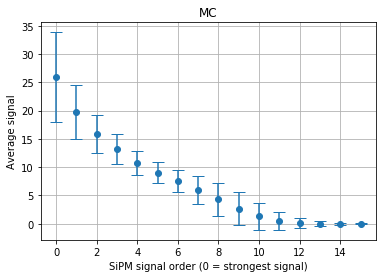

In [31]:
plt.errorbar(sipm_nums, avg_sipms, yerr = avg_spread, fmt = 'o', capsize = 6)
plt.xlabel('SiPM signal order (0 = strongest signal)')
plt.ylabel('Average signal')
if MC:
    plt.title('MC')
else:
    plt.title('Data, run = '+str(run_number))
plt.grid()
plt.show()

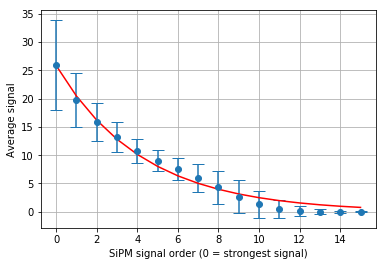

[25.83988923  0.23396714]


In [32]:
# Fit exponential decay to curve

from scipy.optimize import curve_fit

def exp(x, a, b):
    return a * np.exp(-b * x)

#def inv(x, a, b, c, d):
#    return a / (d + np.power(abs(x - b), c))

popt_exp, pcov_exp = curve_fit(exp, sipm_nums, avg_sipms)
#popt_inv, pcov_inv = curve_fit(inv, sipm_nums, avg_sipms)

sipm_nums = np.array(sipm_nums)

plt.errorbar(sipm_nums, avg_sipms, yerr = avg_spread, fmt = 'o', capsize = 6)
plt.xlabel('SiPM signal order (0 = strongest signal)')
plt.ylabel('Average signal')
plt.plot(sipm_nums, exp(sipm_nums, *popt_exp), 'r-')
#plt.plot(sipm_nums, inv(sipm_nums, *popt_inv), 'g--')
plt.grid()
plt.show()

print(popt_exp)

In [33]:
print(avg_sipms)

[25.888075926903593, 19.691803696225225, 15.84332095835617, 13.161929432675402, 10.707414788736553, 9.014924326763598, 7.54078958102242, 5.997778806631423, 4.316927895913051, 2.6764674119961147, 1.3373158040877093, 0.527874423722369, 0.16138970709573408, 0.04460790403687253, 0.007576977485195017, 0.0010310374645109085]


In [44]:
# NEW MC - 500 FILES. Decay constant: 0.2340
known_MC_avg = [25.888075926903593, 19.691803696225225, 15.84332095835617, 13.161929432675402, 10.707414788736553, 9.014924326763598, 7.54078958102242, 5.997778806631423, 4.316927895913051, 2.6764674119961147, 1.3373158040877093, 0.527874423722369, 0.16138970709573408, 0.04460790403687253, 0.007576977485195017, 0.0010310374645109085]

# OLD MC - 50 FILES. Decay constant: 0.2509
# known_MC_avg = [32.446950582576356, 22.642414330014184, 17.94196169419032, 14.564067684158422, 11.821789368009465, 10.080813814584122, 8.26357790016037, 6.769360098639728, 4.963066026183294, 2.8737226480518148, 1.6115713280664516, 0.6865329211559256, 0.24598980423944372, 0.03331484235304724, 0.010266498353324875]

# Decay constant: 0.2189
known_Data_avg_7851_0to20 = [118.35718705340145, 85.60926762650648, 64.88816617267895, 53.83612638333949, 41.34883529849176, 35.37706507799105, 29.763288532350117, 24.458116282021116, 20.67501141897063, 17.405608642857278, 15.07093955947132, 13.177858004221111, 11.42506666927803, 9.888952463661743, 8.579869079589848, 7.443799052354766, 6.42225849198132, 5.287538613110057, 4.096561057858346, 3.0706209796812476, 2.09772243964963, 1.2847259963431, 0.6667159173546765, 0.32472266080902845, 0.20261161990282014, 0.09678425626056951, 0.05819402555140054, 0.022324702565262956, 0.021821929187309453, 0.011682822064655584, 0.010850825426055163, 0.010722473888862424, 0.010228031437571455, 0.009510378953887195, 0.009329499035346798, 0.009270848530094798, 0.008960003736542493, 0.008746879391553926, 0.007253189086914063, 0.007235453535870808, 0.006438006889529345, 0.006417962051019436, 0.006389025246224752, 0.006265692361971227, 0.0059922204366544395, 0.005940501980665254, 0.005817656633330555, 0.005744568894549114, 0.005656203293218845, 0.005329595891440787, 0.005301877463736185, 0.005205024160989901, 0.005185858563679021, 0.005107358606850228, 0.005061690167682927, 0.004894547346161633]

# Decay constant: 0.2218
known_Data_avg_7850_0to20 = [119.10549628117171, 85.84162255397364, 65.3237857514644, 54.29688875798675, 40.956309761184215, 34.89218999475122, 29.31595397280504, 24.052565700029476, 20.333593858190703, 17.267844539714535, 14.939490873975112, 13.01464187908934, 11.29700192797231, 9.863897202024416, 8.574326475777944, 7.4142616217829795, 6.30175952702405, 5.251153954471723, 4.16708090770767, 3.0478246625201133, 2.082158042615155, 1.2581304748694728, 0.678165270987735, 0.3272748140699836, 0.1409201873726104, 0.07432022322696519, 0.050967586942877896, 0.022707794766977013, 0.011259928167578708, 0.00955705243752772, 0.009171167692815166, 0.009166570298700218, 0.009136310136650663, 0.008803120647293638, 0.008549703544829472, 0.008520635475675423, 0.00792190658143792, 0.0075928124773549845, 0.007481080127427302, 0.007374557365934212, 0.007338170511314118, 0.0071419643690861555, 0.006576629273919945, 0.006531251854155643, 0.006412083409221999, 0.006394471780237449, 0.006299804406337054, 0.005856409015883487, 0.005763319858991768, 0.005494392250638559, 0.005232476143248053, 0.005133448843936996, 0.005043326621036606]

# Decay constant: 0.2203
known_Data_avg_7851_1000to1020 = [119.77477146017151, 85.50933711611003, 65.26900343683546, 54.60737305439168, 41.223931183838516, 35.30197904051227, 29.39821760713171, 24.32503930171723, 20.50496926331166, 17.47024637513559, 15.202621119362977, 13.313321891089359, 11.572141796732165, 10.106743976987627, 8.832109536325984, 7.654775360182603, 6.518681066259376, 5.369468209778738, 4.303027772668547, 3.1586712752656987, 2.2227596071553344, 1.4074498857770648, 0.798368910615667, 0.41115097506292936, 0.19909120334193034, 0.11263914296192488, 0.05791487200506802, 0.04032353697151973, 0.009951758737047317, 0.004935211031307728]

# Decay constant: 0.2204
known_Data_avg_7850_1000to1020 = [118.39726912085668, 85.64230392228319, 65.93262695732398, 54.4342532851803, 41.05310585427641, 34.98616068576709, 29.454869946437082, 24.123084783554052, 20.38641983582014, 17.222139723710157, 14.891911351858695, 13.014920754219148, 11.316485779054137, 9.892522428907567, 8.650424231344209, 7.423025670781061, 6.3472796300453975, 5.217888691532079, 4.119387003468042, 2.936694190573338, 1.8643489609013753, 1.1412801973855318, 0.5763962980526596, 0.2764683881802345, 0.15071199456257603, 0.0681006419124888, 0.03396953086354839, 0.019344159471454906, 0.004786615941061902]


# min_data = min(len(known_Data_avg_7850_to20), len(known_Data_avg_7851_0to20))
# sipm_nums_min_data =[x for x in range(min_data)]

# plt.plot(sipm_nums_min_data, known_Data_avg_7850_0to20[:min_data], 'o')
# plt.plot(sipm_nums_min_data, known_Data_avg_7851_0to20[:min_data], 'o')
# plt.grid()
# plt.show()

In [45]:
def curve_compare(curve_1, curve_2, name):
    curve_compare_1 = curve_1[:num_sipms_cap]
    curve_compare_2 = curve_2[:num_sipms_cap]
    ratio = [curve_compare_1[i] / curve_compare_2[i] for i in range(min(len(curve_compare_1), len(curve_compare_2)))]
    sipm_nums_min = [x for x in range(len(ratio))]
    plt.plot(sipm_nums_min, ratio, 'o')
    plt.xlabel('SiPM signal order')
    plt.ylabel('Signal ratio')
    plt.title(name)
    plt.grid()
    plt.show()

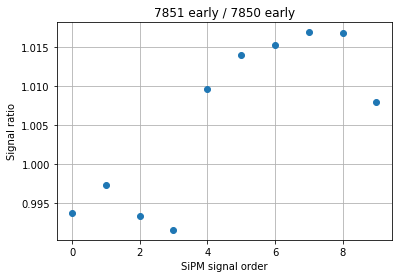

In [46]:
curve_compare(known_Data_avg_7851_0to20, known_Data_avg_7850_0to20, '7851 early / 7850 early')

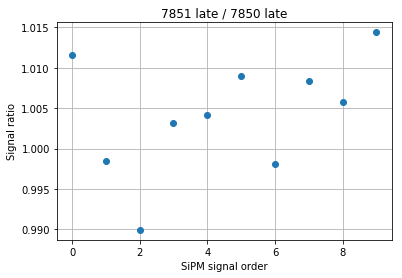

In [47]:
curve_compare(known_Data_avg_7851_1000to1020, known_Data_avg_7850_1000to1020, '7851 late / 7850 late')

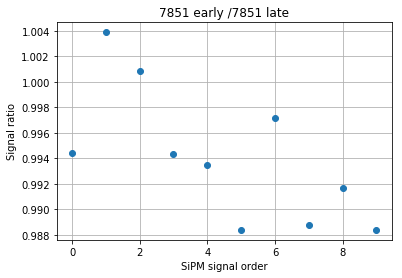

In [48]:
curve_compare(known_Data_avg_7850_0to20, known_Data_avg_7851_1000to1020, '7851 early /7851 late')

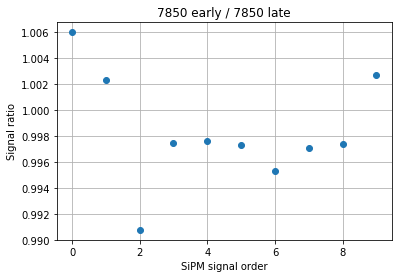

In [49]:
curve_compare(known_Data_avg_7850_0to20, known_Data_avg_7850_1000to1020, '7850 early / 7850 late')

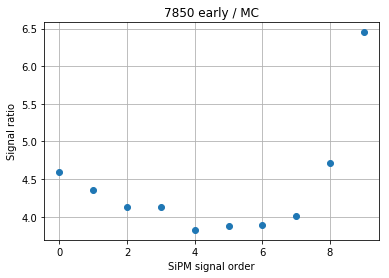

In [50]:
curve_compare(known_Data_avg_7850_0to20, known_MC_avg, '7850 early / MC')

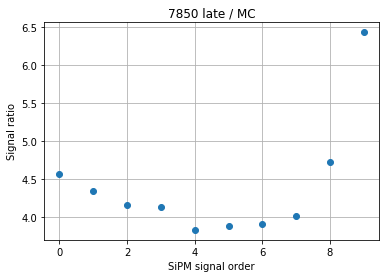

In [51]:
curve_compare(known_Data_avg_7850_1000to1020, known_MC_avg, '7850 late / MC')

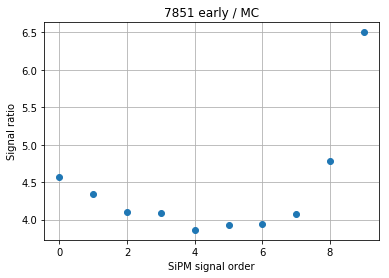

In [52]:
curve_compare(known_Data_avg_7851_0to20, known_MC_avg, '7851 early / MC')

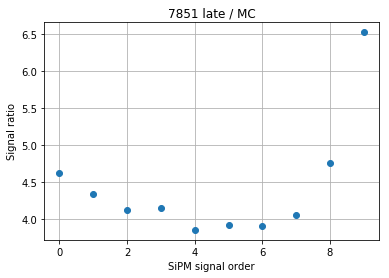

In [53]:
curve_compare(known_Dat.a_avg_7851_1000to1020, known_MC_avg, '7851 late / MC')